## PWAD - Precipitation Weighted Area Distribution

The distribution of area of contiguous convective regions (objects) weighted by the precipitation rate of respective object, in bins with width equal to the effective radius of a gridbox of the common grid<br>

In [37]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import skimage.measure as skm

from os.path import expanduser
home = expanduser("~")

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [38]:
from plotFuncs import *

### one dataset

In [41]:
metric = 'oAreaAndPr'

o_areaPr_options= [
    'o_area'
    # 'o_pr'
    ]

models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]

observations = [
    # 'GPCP'
    ]

datasets = models + observations

resolutions = [
    # 'original',
    'regridded'
    ]

experiments = [
    'historical',
    # 'rcp85'
    ]


print('variable:{}, dataset:{}, experiment:{}, resolution:{}'.format(metric, datasets[0], experiments[0], resolutions[0]))
ds = get_metric(metric, datasets[0], experiments[0], resolution=resolutions[0])
ds

variable:oAreaAndPr, dataset:GFDL-CM3, experiment:historical, resolution:regridded


<xarray.Dataset>
Dimensions:  (region: 181628)
Dimensions without coordinates: region
Data variables:
    o_area   (region) float64 ...
    o_pr     (region) float64 ...
Attributes:
    descrption:  area and precipipitation rate of contiguous convective regio...

In [42]:
data = ds[o_areaPr_options[0]]
data

<xarray.DataArray 'o_area' (region: 181628)>
[181628 values with dtype=float64]
Dimensions without coordinates: region
Attributes:
    units:    km²

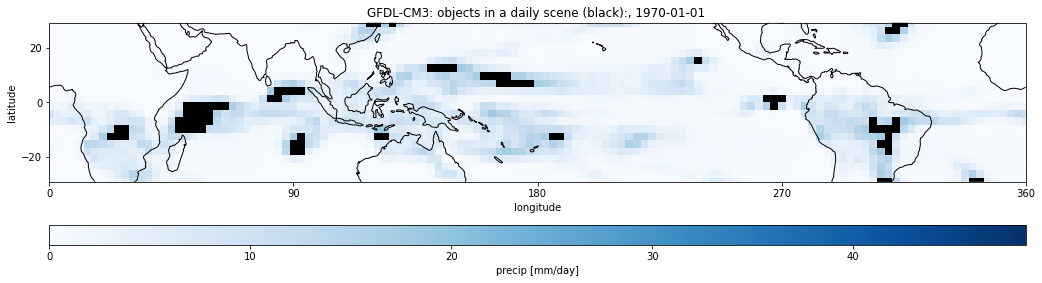

In [89]:
scene = get_dsvariable('precip', datasets[0],experiments[0],home, resolutions[0])['precip'].isel(time=0)
conv_threshold = get_metric('prPercentiles', datasets[0], experiments[0])['pr97'].mean(dim=('time'))

lat = scene.lat
lon = scene.lon
lonm,latm = np.meshgrid(lon,lat)

obj = skm.label(scene.where(scene>=conv_threshold,0)>0, background=np.nan,connectivity=2)
obj = (obj>0)*1
labelMatrix = xr.DataArray(
    data=obj,
    dims=['lat', 'lon'],
    coords={'lat': scene.lat.data, 'lon': scene.lon.data}
    )
obj = labelMatrix.where(labelMatrix>0)


fig= plt.figure(figsize=(17.5,8))
ax = fig.add_subplot(projection=cartopy.crs.PlateCarree(central_longitude=180))

ax.add_feature(cartopy.feature.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

pcm = ax.pcolormesh(lonm,latm, scene,transform=cartopy.crs.PlateCarree(),zorder=0, cmap='Blues') #, vmin=10, vmax=50)
ax.pcolormesh(lonm,latm, obj,transform=cartopy.crs.PlateCarree(), cmap='Greys_r')

ax.set_title(datasets[0] + ': objects in a daily scene (black):' + ', ' + str(scene.coords['time'].values)[:11] )
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_yticks([-20, 0, 20])
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])

plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'precip' + ' [mm/day]')

Text(0, 0.5, 'Nb of objects [Nb]')

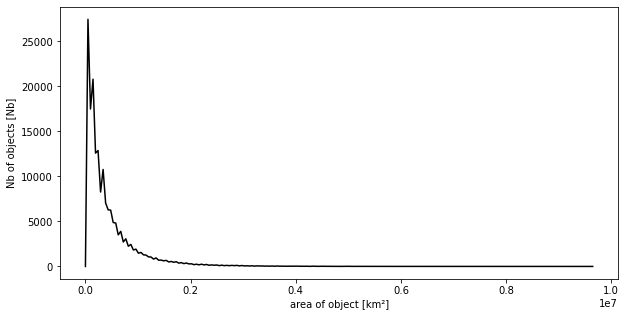

In [57]:
x = ds['o_area']

bin_width = (x.max() - x.min())/200
bin_end = x.max()
bins = np.arange(0, bin_end+bin_width, bin_width)

y_bins = []
for i in np.arange(0,len(bins)-1):
    y_bins = np.append(y_bins, ((x>=bins[i]) & (x<bins[i+1])).sum())

plt.figure(figsize = (10,5))
ax = plt.gca()

ax.plot(bins[:-1], y_bins, 'k')
ax.set_xlabel('area of object [{}]'.format('km\u00b2'))
ax.set_ylabel('Nb of objects [{}]'.format('Nb'))
ax.set_title('Number of objects per area bin')


Text(0, 0.5, 'Nb of objects []')

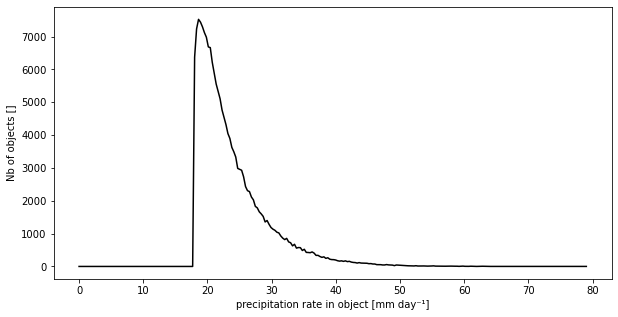

In [58]:
x = ds['o_pr']
bin_width = (x.max() - x.min())/200
bin_end = x.max()
bins = np.arange(0, bin_end+bin_width, bin_width)

y_bins = []
for i in np.arange(0,len(bins)-1):
    y_bins = np.append(y_bins, ((x>=bins[i]) & (x<bins[i+1])).sum())

plt.figure(figsize = (10,5))
ax = plt.gca()

ax.plot(bins[:-1], y_bins, 'k')
ax.set_xlabel('precipitation rate in object [{}]'.format('mm day' + chr(0x207B) + chr(0x00B9)))
ax.set_ylabel('Nb of objects []'.format('Nb'))
ax.set_title('Precipitation rate per precipitation bin')

Text(0, 0.5, 'PWAD [%]')

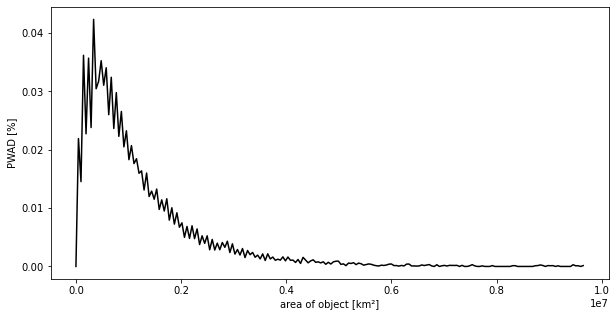

In [62]:
x = ds['o_area']
o_pr = ds['o_pr']

bin_width = (x.max() - x.min())/200
bin_end = x.max()
bins = np.arange(0, bin_end+bin_width, bin_width)

y_bins = []
for i in np.arange(0,len(bins)-1):
    y_bins = np.append(y_bins, np.sum((((x>=bins[i]) & (x<bins[i+1]))>0)*x*o_pr)/np.sum(x*o_pr))

plt.figure(figsize = (10,5))
ax = plt.gca()

ax.plot(bins[:-1], y_bins, 'k')
ax.set_xlabel('area of object [{}]'.format('km\u00b2'))
ax.set_ylabel('PWAD [{}]'.format('%'))
ax.set_title('Precipitation per area bin')

In [66]:
def r_eff(area):
    return np.sqrt(area/np.pi)


In [68]:
# finding effective radius of mean gridbox
scene = get_dsvariable('precip', datasets[0],experiments[0],home, resolutions[0])['precip'].isel(time=0)
lat = scene.lat.data
lon = scene.lon.data
lonm,latm = np.meshgrid(lon,lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
R = 6371
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

area_gridbox = np.mean(aream)
radius_gridbox = r_eff(area_gridbox)
radius_gridbox

171.56802109167054

Text(0.5, 1.0, 'Precipitation per area bin (as effective radius), dataset:GFDL-CM3, experiment:historical')

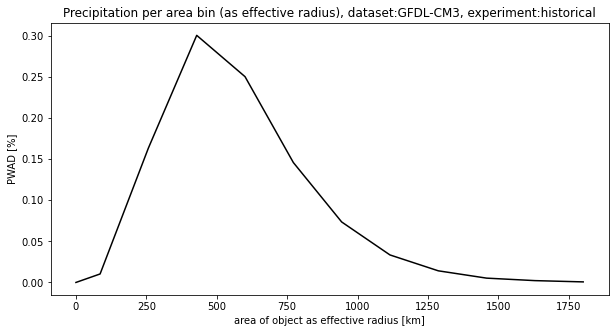

In [91]:
x = ds['o_area']
o_pr = ds['o_pr']

bin_width = radius_gridbox #(r_eff(x.max()) - r_eff(x.min()))/100
bin_end = r_eff(x.max())
bins = np.arange(0, bin_end+bin_width, bin_width)

y_bins = []
for i in np.arange(0,len(bins)-1):
    y_bins = np.append(y_bins, np.sum((((r_eff(x)>=bins[i]) & (r_eff(x)<bins[i+1]))>0)*x*o_pr)/np.sum(x*o_pr))

# place the distribution that falls between the edges of a bin in the middle of the bin, and describe that no objects have zero area
y_bins_middle = np.append(0, y_bins)
bins_middle = np.append(0,bins+0.5*bin_width) 

plt.figure(figsize = (10,5))
ax = plt.gca()

if len(y_bins) < len(bins):
    ax.plot(bins_middle[:-1], y_bins_middle, 'k')
else:
    ax.plot(bins_middle, y_bins_middle, 'g')


ax.set_xlabel('area of object as effective radius [{}]'.format('km'))
ax.set_ylabel('PWAD [{}]'.format('%'))
ax.set_title('Precipitation per area bin (as effective radius), dataset:{}, experiment:{}'.format(datasets[0], experiments[0]))

### comparing datasets

In [93]:
models = [
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    'GISS-E2-H',    # 3
    'bcc-csm1-1',   # 4
    'CNRM-CM5',     # 5
    'CCSM4',        # 6
    'HadGEM2-AO',   # 7
    'BNU-ESM',      # 8
    'EC-EARTH',     # 9
    'FGOALS-g2',    # 10
    'MPI-ESM-MR',   # 11
    'CMCC-CM',      # 12
    'inmcm4',       # 13
    'NorESM1-M',    # 14
    'CanESM2',      # 15
    'MIROC5',       # 16
    'HadGEM2-CC',   # 17
    'MRI-CGCM3',    # 18
    'CESM1-BGC'     # 19
    ]

observations = [
    'GPCP' # 20
    ]

datasets = models + observations

experiments =[
    'historical',
    # 'rcp85'
    ]

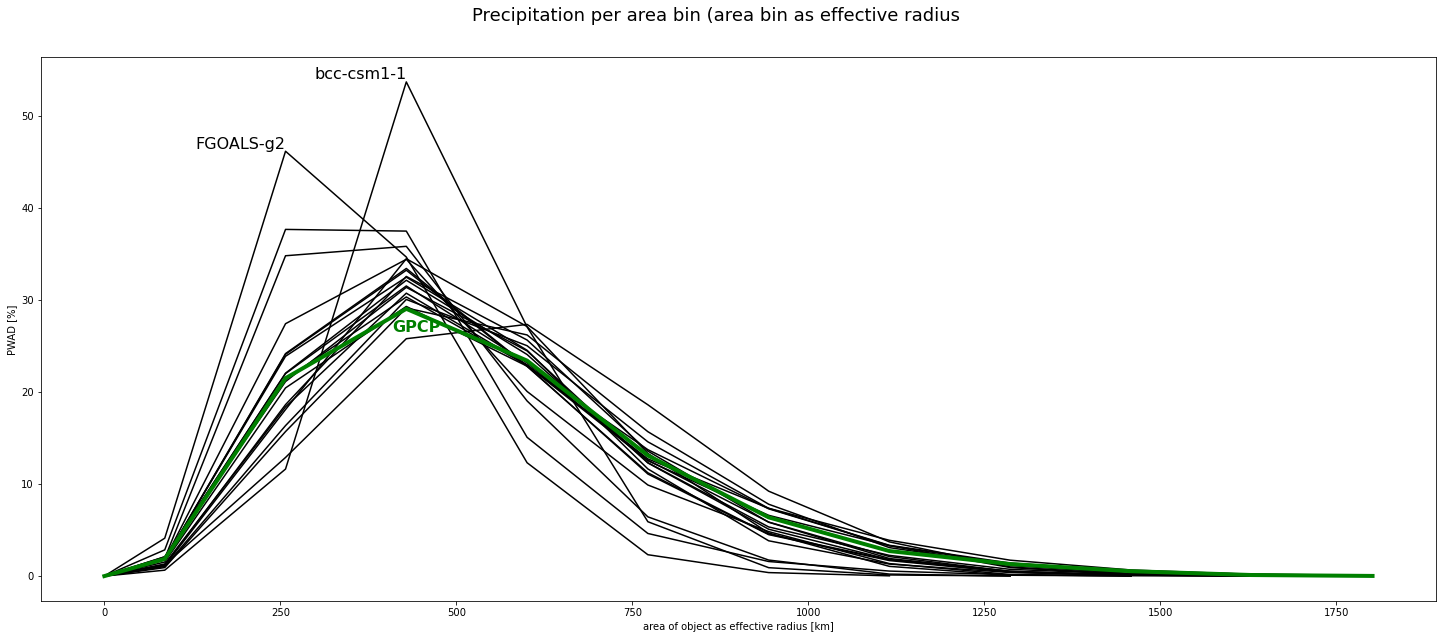

In [131]:
scene = get_dsvariable('precip', datasets[0],experiments[0],home, resolutions[0])['precip'].isel(time=0)
lat = scene.lat.data
lon = scene.lon.data
lonm,latm = np.meshgrid(lon,lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
R = 6371
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

area_gridbox = np.mean(aream)
radius_gridbox = r_eff(area_gridbox)
bin_width = radius_gridbox

absolute_limits = True
quantile_low = 0
quantile_high = 1
if absolute_limits:
    vmin, vmax = [], []
    for dataset in datasets:

        data = get_metric(metric, dataset, experiments[0])['o_area']
        x= data

        vmin = np.append(vmin, np.quantile(x, quantile_low))
        vmax = np.append(vmax, np.quantile(x, quantile_high))

    vmin = np.min(vmin)
    vmax = np.max(vmax)

else:
    vmin, vmax = None, None 


fig= plt.figure(figsize=(25,10))
title = 'Precipitation per area bin (area bin as effective radius'

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):

    ds = get_metric(metric, dataset, experiments[0])
    x= ds['o_area']
    o_pr = ds['o_pr']
    
    bin_end = r_eff(x.max())
    bins = np.arange(0, bin_end+bin_width, bin_width)

    y_bins = []
    for i in np.arange(0,len(bins)-1):
        y_bins = np.append(y_bins, np.sum((((r_eff(x)>=bins[i]) & (r_eff(x)<bins[i+1]))>0)*x*o_pr)/np.sum(x*o_pr)*100)

    # place the distribution that falls between the edges of a bin in the middle of the bin, and describe that no objects have zero area
    y_bins_middle = np.append(0, y_bins)
    bins_middle = np.append(0,bins+0.5*bin_width) 
    
    ax = plt.gca()
    
    if dataset=='GPCP':
        ax.plot(bins_middle[:-1], y_bins_middle, linewidth = 4, color = 'g')

    ax.plot(bins_middle[:-1], y_bins_middle, 'k', zorder=0)

    max_index = np.argmax(y_bins_middle)
    max_x = bins_middle[max_index]
    
    if dataset == 'bcc-csm1-1' or dataset == 'FGOALS-g2' or dataset == 'canESM2':
        ax.text(max_x, y_bins_middle[max_index], dataset, ha='right', va='bottom', fontsize=16, color='k')

    if dataset == 'GPCP':
        ax.text(max_x-20, y_bins_middle[max_index]-2.5, dataset, fontsize=16, color='g', weight='bold') 


    ax.set_xlabel('area of object as effective radius [{}]'.format('km'))
    ax.set_ylabel('PWAD [{}]'.format('%'))




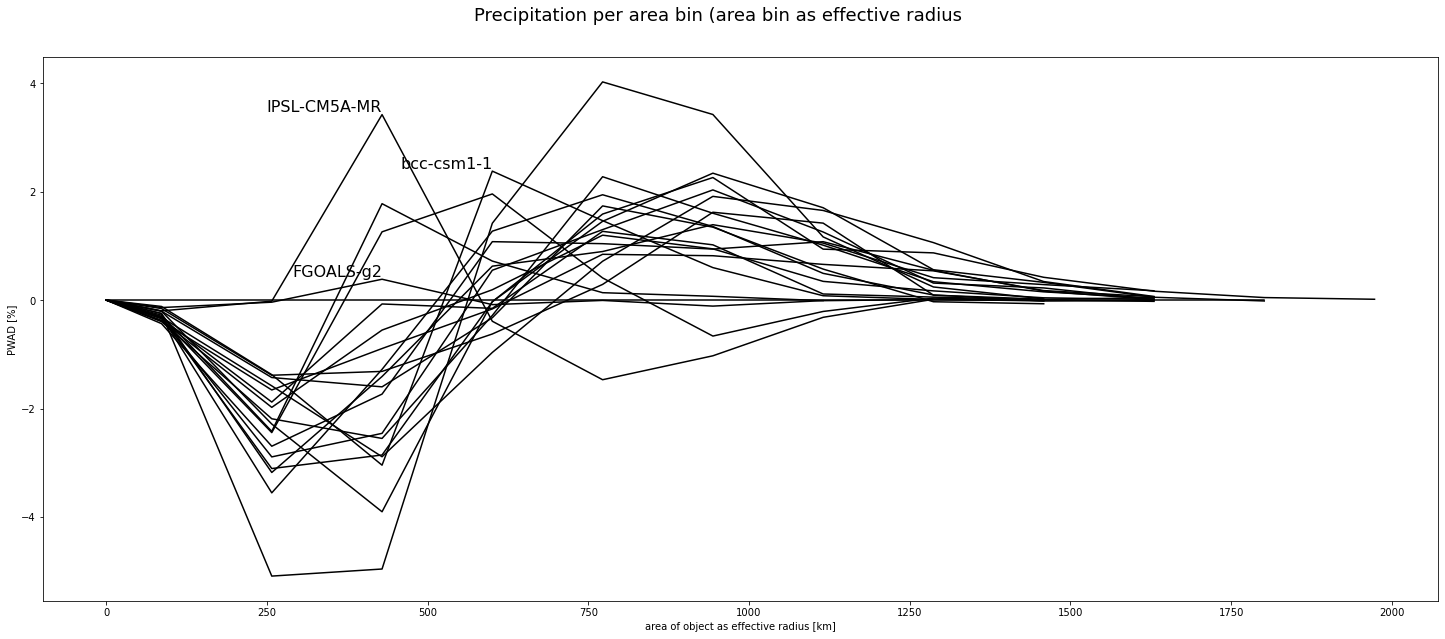

In [140]:
scene = get_dsvariable('precip', datasets[0],experiments[0],home, resolutions[0])['precip'].isel(time=0)
lat = scene.lat.data
lon = scene.lon.data
lonm,latm = np.meshgrid(lon,lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
R = 6371
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

area_gridbox = np.mean(aream)
radius_gridbox = r_eff(area_gridbox)
bin_width = radius_gridbox

absolute_limits = True
quantile_low = 0
quantile_high = 1
if absolute_limits:
    vmin, vmax = [], []
    for dataset in datasets:

        data_historical = get_metric(metric, dataset, experiment='historical')['o_area']
        data_rcp = get_metric(metric, dataset, experiment='rcp85')['o_area']

        vmin = np.append(vmin, np.min([np.quantile(data_historical, quantile_low), np.quantile(data_rcp, quantile_low)]))
        vmax = np.append(vmax, np.max([np.quantile(data_historical, quantile_high), np.quantile(data_rcp, quantile_high)]))

    vmin = np.min(vmin)
    vmax = np.max(vmax)

else:
    vmin, vmax = None, None 


fig= plt.figure(figsize=(25,10))
title = 'Precipitation per area bin (area bin as effective radius'

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):

    ds = get_metric(metric, dataset, experiment='historical')
    x1 = ds['o_area']
    o_pr1 = ds['o_pr']

    ds = get_metric(metric, dataset, experiment='rcp85')
    x2 = ds['o_area']
    o_pr2 = ds['o_pr']

    bin_end = r_eff(np.max([np.max(x1), np.max(x2)]) )
    bins = np.arange(0, bin_end+bin_width, bin_width)

    y_bins1 = []
    for i in np.arange(0,len(bins)-1):
        y_bins1 = np.append(y_bins1, np.sum((((r_eff(x1)>=bins[i]) & (r_eff(x1)<bins[i+1]))>0)*x1*o_pr1)/np.sum(x1*o_pr1)*100)

    y_bins2 = []
    for i in np.arange(0,len(bins)-1):
        y_bins2 = np.append(y_bins2, np.sum((((r_eff(x2)>=bins[i]) & (r_eff(x2)<bins[i+1]))>0)*x2*o_pr2)/np.sum(x2*o_pr2)*100)

    # place the distribution that falls between the edges of a bin in the middle of the bin, and describe that no objects have zero area
    y_bins = y_bins2 - y_bins1
    y_bins_middle = np.append(0, y_bins)
    bins_middle = np.append(0,bins+0.5*bin_width) 
    
    ax = plt.gca()

    ax.plot(bins_middle[:-1], y_bins_middle, 'k', zorder=0)

    max_index = np.argmax(y_bins_middle)
    max_x = bins_middle[max_index]
    
    if dataset == 'bcc-csm1-1' or dataset == 'FGOALS-g2' or dataset == 'IPSL-CM5A-MR':
        ax.text(max_x, y_bins_middle[max_index], dataset, ha='right', va='bottom', fontsize=16, color='k')

    ax.set_xlabel('area of object as effective radius [{}]'.format('km'))
    ax.set_ylabel('PWAD [{}]'.format('%'))



Text(0, 0.5, 'area [km²]')

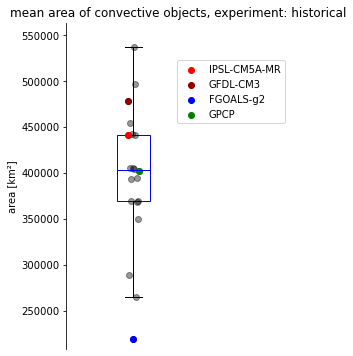

In [132]:
labels =[
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    'GPCP'            # 20
    ]
colors = [
    'r',
    'darkred',
    'b', 
    'g'
    ]

absolute_limits = True
quantile_low = 0
quantile_high = 1
if absolute_limits:
    vmin, vmax = [], []
    for dataset in datasets:

        ds = get_metric(metric, dataset, experiments[0])
        y = ds['o_area'].mean(dim='region')

        vmin = np.append(vmin, np.quantile(y, quantile_low))
        vmax = np.append(vmax, np.quantile(y, quantile_high))

    vmin = np.min(vmin)
    vmax = np.max(vmax)

else:
    vmin, vmax = None, None 



plt.figure(figsize=(4,6))
title = 'mean area of convective objects, experiment: {}'.format(experiments[0])
plt.xlim(0,1)
plt.ylim(vmin*0.95, vmax*1.05)

y= []
for dataset in datasets:
        
    ds = get_metric(metric, dataset, experiments[0])
    y_data = ds['o_area'].mean(dim='region')

    y = np.append(y, y_data)

plt.boxplot(y,vert=True, positions= [0.3], patch_artist=True, medianprops = dict(color="b",linewidth=1),boxprops = dict(color="b",facecolor='w',zorder=0)
            ,sym='+',flierprops = dict(color="r"))

x = np.linspace(0.3-0.025, 0.3+0.025, len(y))
plt.scatter(x, y, c='k', alpha=0.4)

if labels:
    for i, label in enumerate(labels):
        dataset_idx= datasets.index(label)
        plt.scatter(x[dataset_idx],y[dataset_idx],c=colors[i], label=label)
        plt.legend(bbox_to_anchor=(0.6,0.5,0.4,0.4))

plt.xticks([])
sns.despine(top=True, right=True, left=False, bottom=True)
plt.title(title)
plt.ylabel('area [{}]'.format(data.units))

Text(0, 0.5, 'area [km² K⁻¹]')

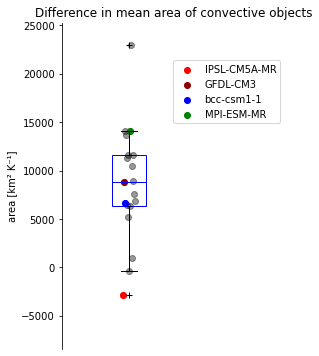

In [134]:
labels =[
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3
    'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]
colors = [
    'r',
    'darkred',
    'b', 
    'g'
    ]


absolute_limits = True
quantile_low = 0
quantile_high = 1
if absolute_limits:
    vmin, vmax = [], []
    for dataset in datasets:

        if dataset == 'GPCP':
            continue
        
        data_historical = get_metric(metric, dataset, experiment='historical')['o_area'].mean(dim='region')
        data_rcp = get_metric(metric, dataset, experiment='rcp85')['o_area'].mean(dim='region')

        tas_historical = get_dsvariable(variable='tas', dataset=dataset, experiment='historical')['tas']
        aWeights = np.cos(np.deg2rad(tas_historical.lat))
        tas_historical = get_dsvariable(variable='tas', dataset=dataset, experiment='historical')['tas'].weighted(aWeights).mean(dim=('time','lat','lon'))
        tas_rcp85 = get_dsvariable(variable='tas', dataset=dataset, experiment='rcp85')['tas'].weighted(aWeights).mean(dim=('time','lat','lon'))

        datadiff = data_rcp - data_historical
        # datadiff = (datadiff/data_historical)*100

        tasdiff = tas_rcp85 - tas_historical
        datadiff = datadiff/tasdiff

        y= datadiff

        vmin = np.append(vmin, np.quantile(y, quantile_low))
        vmax = np.append(vmax, np.quantile(y, quantile_high))

    vmin = np.min(vmin)
    vmax = np.max(vmax)

else:
    vmin, vmax = None, None 



plt.figure(figsize=(4,6))
title = 'Difference in mean area of convective objects'
plt.xlim(0,1)
plt.ylim(vmin*0.95, vmax*1.05)

y= []
for dataset in datasets:

    if dataset == 'GPCP':
        continue

    data_historical = get_metric(metric, dataset, experiment='historical')['o_area'].mean(dim='region')
    data_rcp = get_metric(metric, dataset, experiment='rcp85')['o_area'].mean(dim='region')

    tas_historical = get_dsvariable(variable='tas', dataset=dataset, experiment='historical')['tas']
    aWeights = np.cos(np.deg2rad(tas_historical.lat))
    tas_historical = get_dsvariable(variable='tas', dataset=dataset, experiment='historical')['tas'].weighted(aWeights).mean(dim=('time','lat','lon'))
    tas_rcp85 = get_dsvariable(variable='tas', dataset=dataset, experiment='rcp85')['tas'].weighted(aWeights).mean(dim=('time','lat','lon'))

    datadiff = data_rcp - data_historical
    # datadiff = (datadiff/data_historical)*100

    tasdiff = tas_rcp85 - tas_historical
    datadiff = datadiff/tasdiff

    y = np.append(y, datadiff)

data.attrs['units'] = 'km\u00b2 K'+ chr(0x207B) + chr(0x00B9) 
    
plt.boxplot(y,vert=True, positions= [0.3], patch_artist=True, medianprops = dict(color="b",linewidth=1),boxprops = dict(color="b",facecolor='w',zorder=0)
            ,sym='+',flierprops = dict(color="r"))

x = np.linspace(0.3-0.025, 0.3+0.025, len(y))
plt.scatter(x, y, c='k', alpha=0.4)

if labels:
    for i, label in enumerate(labels):
        dataset_idx= datasets.index(label)
        plt.scatter(x[dataset_idx],y[dataset_idx],c=colors[i], label=label)
        plt.legend(bbox_to_anchor=(0.6,0.5,0.4,0.4))

plt.ylim([3*vmin,1.1*vmax])
plt.xticks([])
sns.despine(top=True, right=True, left=False, bottom=True)
plt.title(title)
plt.ylabel('area [{}]'.format(data.units))